# Randomized Search with Hyperopt

In this notebook, we will perform Randomized Search to select the best hyperparameters for a Gradient Boosting Classifier, using the open source Python package Hyperopt.

The randomized search is performed with the class rand.

I find the documentation for Hyperopt quite unintuitive, so it helps to refer to the original article to understand the different parameters and classes.

To step out of Scikit-learn, we will optimise the parameters of a Gradient Boosting Machine of the xgboost package.
Procedure

To tune the hyper-parameters of our model we need to:

    define a model
    define the hyperparameter space
    define the objective function we want to minimize.



In [1]:
%pylab inline
%load_ext autoreload
%autoreload 2

Populating the interactive namespace from numpy and matplotlib


In [2]:
import sys
sys.path.insert(0,'../..')
import omama as O
import numpy as np
import pandas as pd
import sklearn
import warnings
import matplotlib.pyplot as plt

from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score, train_test_split

from scipy.spatial.distance import braycurtis, canberra, chebyshev, correlation, dice, hamming, jaccard, kulsinski, mahalanobis, matching, minkowski, rogerstanimoto, russellrao, seuclidean, sokalmichener, sokalsneath, sqeuclidean, yule
import scipy

from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.tree import DecisionTreeClassifier
from sklearn.cluster import KMeans
from sklearn import datasets, cluster

from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight

from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings("ignore", category=ConvergenceWarning)

from hyperopt import hp, rand, fmin, Trials
from pyod.models.knn import KNN
import pickle
import wandb

In [3]:
with open('/raid/mpsych/datasetA.pkl','rb') as f:
    datasetA_X = pickle.load(f)
    
with open('/raid/mpsych/datasetA_labels.pkl', 'rb') as f1:
    labels = np.asarray(pickle.load(f1))

In [51]:
X_feat_vect, filtered = O.Features.get_features(datasetA_X, 'hist', 'gaussian', sigma=20)

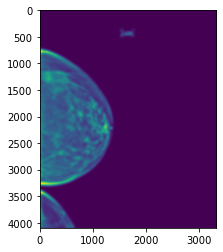

In [52]:
imshow(filtered[28])

In [53]:
X_feat_vect[:3]

[array([3145750,   16160,   10108,    7546,    6080,    5116,    4501,
           3964,    3589,    3314,    3038,    2847,    2637,    2488,
           2383,    2270,    2159,    2020,    2014,    1911,    1832,
           1797,    1737,    1661,    1623,    1575,    1585,    1477,
           1500,    1426,    1415,    1370,    1385,    1316,    1317,
           1293,    1275,    1256,    1230,    1177,    1233,    1177,
           1170,    1174,    1111,    1146,    1106,    1103,    1126,
           1055,    1089,    1049,    1061,    1073,    1033,    1047,
           1017,    1026,    1009,    1023,    1001,    1000,     996,
           1002,     955,    1009,     990,     948,     975,     989,
            957,     979,     967,     942,     989,     960,     940,
            983,     934,     992,     955,     963,     966,     963,
            929,    1001,     961,     991,     951,     961,    1004,
            967,     983,    1013,     962,    1024,    1011,     990,
      

In [54]:
X = pd.DataFrame(X_feat_vect)

In [55]:
y = pd.Series(labels)

In [56]:
# the target:
# percentage of unwanted images (0) to wanted images (1)

y.value_counts() / len(y)

0    0.92
1    0.08
dtype: float64

In [57]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=0
)
X_train.shape, X_test.shape

((80, 256), (20, 256))

In [58]:
X_train

,0,1,2,3,4,5,6,7,8,9,...,246,247,248,249,250,251,252,253,254,255
43,0,0,0,0,0,0,0,0,0,0,...,8652,9320,12019,14152,10619,7692,5404,2588,1790,1
62,0,0,0,0,0,0,0,0,0,0,...,4108,4378,2661,1819,1442,1233,523,433,399,1
3,0,0,0,0,0,0,0,0,0,0,...,2523,2697,2876,3361,2426,2210,2382,1118,760,1
71,0,0,0,0,0,0,0,0,0,0,...,51,57,60,59,68,75,104,83,74,1
45,9109678,51444,34771,27999,24230,22069,20657,19973,19810,20021,...,125,115,123,115,121,125,119,125,122,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96,9306405,29365,18657,14007,11361,9705,8509,7581,6936,6392,...,57,61,63,57,57,55,66,55,59,1
67,5727330,27891,17744,13292,10851,9329,8092,7358,6663,6179,...,294,260,249,231,206,204,195,187,181,1
64,5203277,24739,15512,11421,9214,7846,6682,6157,5367,4907,...,221,217,193,183,181,158,155,146,140,1
47,523925,550646,479053,839390,251338,21221,12627,9406,7566,6409,...,12573,15515,19801,25927,34339,46233,66328,110929,455360,1


In [59]:
print(dict(y_train))

{43: 0, 62: 0, 3: 0, 71: 0, 45: 0, 48: 1, 6: 0, 99: 0, 82: 0, 76: 0, 60: 0, 80: 0, 90: 1, 68: 0, 51: 0, 27: 1, 18: 0, 56: 0, 63: 1, 74: 0, 1: 0, 61: 1, 42: 0, 41: 0, 4: 0, 15: 0, 17: 0, 40: 0, 38: 1, 5: 0, 91: 0, 59: 0, 0: 0, 34: 0, 28: 0, 50: 0, 11: 0, 35: 0, 23: 0, 52: 0, 10: 0, 31: 0, 66: 0, 57: 0, 79: 0, 85: 0, 32: 0, 84: 0, 14: 0, 89: 0, 19: 0, 29: 0, 49: 0, 97: 0, 98: 0, 69: 0, 20: 0, 94: 0, 72: 0, 77: 0, 25: 0, 37: 0, 81: 1, 46: 0, 39: 0, 65: 0, 58: 0, 12: 0, 88: 0, 70: 0, 87: 0, 36: 0, 21: 0, 83: 0, 9: 0, 96: 0, 67: 0, 64: 0, 47: 1, 44: 0}


In [60]:
np.where(np.array(labels) > 0)

(array([27, 38, 47, 48, 61, 63, 81, 90]),)

## Define the Hyperparameter Space

- [Hyperopt search space](http://hyperopt.github.io/hyperopt/getting-started/search_spaces/)

- [xgb.XGBClassifier hyperparameters](https://xgboost.readthedocs.io/en/latest/python/python_api.html#xgboost.XGBClassifier)

- [xgb general parameters](https://xgboost.readthedocs.io/en/latest/parameter.html)

In [61]:
# determine the hyperparameter space

param_grid = {
    'contamination': hp.uniform('contamination', 0.07, .1),
    'n_neighbors': hp.uniformint('n_neighbors', 1, 50),
    'method': hp.choice('method', ['largest', 'mean', 'median']),
    'radius': hp.quniform('radius', 0.0, 5.0, .1),
    'leaf_size': hp.uniformint('leaf_size', 1, 100),
    'metric': hp.choice('metric', ['minkowski', 'cityblock', 'euclidean', 'l1', 'l2', 'manhattan', 
                                  ]),
    'p': hp.uniformint('p', 1, 10),
    'n_jobs': hp.uniformint('n_jobs', 1, 4)
}

In [62]:
sklearn.metrics.SCORERS.keys()

dict_keys(['explained_variance', 'r2', 'max_error', 'neg_median_absolute_error', 'neg_mean_absolute_error', 'neg_mean_absolute_percentage_error', 'neg_mean_squared_error', 'neg_mean_squared_log_error', 'neg_root_mean_squared_error', 'neg_mean_poisson_deviance', 'neg_mean_gamma_deviance', 'accuracy', 'top_k_accuracy', 'roc_auc', 'roc_auc_ovr', 'roc_auc_ovo', 'roc_auc_ovr_weighted', 'roc_auc_ovo_weighted', 'balanced_accuracy', 'average_precision', 'neg_log_loss', 'neg_brier_score', 'adjusted_rand_score', 'rand_score', 'homogeneity_score', 'completeness_score', 'v_measure_score', 'mutual_info_score', 'adjusted_mutual_info_score', 'normalized_mutual_info_score', 'fowlkes_mallows_score', 'precision', 'precision_macro', 'precision_micro', 'precision_samples', 'precision_weighted', 'recall', 'recall_macro', 'recall_micro', 'recall_samples', 'recall_weighted', 'f1', 'f1_macro', 'f1_micro', 'f1_samples', 'f1_weighted', 'jaccard', 'jaccard_macro', 'jaccard_micro', 'jaccard_samples', 'jaccard_wei

In [68]:
params = param_grid
wandb.init(
    # set the wandb project where this run will be logged
    project="omama-hyperopt",
)

## Define the objective function

This is the hyperparameter response space, the function we want to minimize.

In [69]:
# the objective function takes the hyperparameter space
# as input

def objective(params):

    # we need a dictionary to indicate which value from the space
    # to attribute to each value of the hyperparameter in the xgb
    params_dict = {
        'contamination': params['contamination'],
        'n_neighbors': int(params['n_neighbors']),
        'method':params['method'],
        'radius': params['radius'],
        'leaf_size': int(params['leaf_size']),
        'metric': params['metric'],
        'p': int(params['p']),
        'n_jobs': int(params['n_jobs'])
    }
    

    # with ** we pass the items in the dictionary as parameters
    # to the KNN algorithm
    clf = KNN(**params_dict)
    clf.fit(X_train)
    
    y_train_scores = clf.decision_scores_
    y_test_scores = clf.decision_function(X_test)
    
    
    
    

    # train with cv
    score = cross_val_score(clf, X_train, y_train,
                            scoring='accuracy', cv=5, n_jobs=4).mean()
    
    y_pred = clf.predict(X_test)
    print(y_pred)
    f1 = sklearn.metrics.f1_score(y_test, y_pred)
    print(f1)
    precision = sklearn.metrics.precision_score(y_test, y_pred)
    print(precision)
    recall = sklearn.metrics.recall_score(y_test, y_pred)
    print(recall)
#     roc_auc = sklearn.metrics.roc_auc_score(y_test, y_pred)
#     print(roc_auc)
    accuracy = sklearn.metrics.accuracy_score(y_test, y_pred)
    print(accuracy)

        
    # track hyperparameters and run metadata
    config={
        'contamination': params['contamination'],
        'n_neighbors': (params['n_neighbors']),
        'method':params['method'],
        'radius': params['radius'],
        'leaf_size': (params['leaf_size']),
        'metric': params['metric'],
        'p': (params['p']),
        'n_jobs': (params['n_jobs']),
        "architecture": "KNN",
        "dataset": "A",
    }
    
    
    wandb.log({"score": score})
    wandb.log({"f1": f1})
    wandb.log({"precision": precision})
    wandb.log({"recall": recall})
    wandb.log({"accuracy": accuracy})


    # to minimize, we negate the score
    return -score

In [70]:
warnings.filterwarnings('ignore')

## Randomized Search

[fmin](http://hyperopt.github.io/hyperopt/getting-started/minimizing_functions/)

In [71]:

search = fmin(
    fn=objective,
    space=param_grid,
    max_evals=50,
    rstate=np.random.default_rng(42),
    algo=rand.suggest,
)

  0%|                                                                                                                                                                  | 0/50 [00:00<?, ?trial/s, best loss=?]

/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(


[0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0]                                                                                                                                                                     
0.0                                                                                                                                                                                                           
0.0                                                                                                                                                                                                           
0.0                                                                                                                                                                                                           
0.95                                                                                                                                                                        

/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(


[1 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0]                                                                                                                                                                     
0.0                                                                                                                                                                                                           
0.0                                                                                                                                                                                                           
0.0                                                                                                                                                                                                           
0.85                                                                                                                                                                        

/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(


[1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0]                                                                                                                                                                     
0.0                                                                                                                                                                                                           
0.0                                                                                                                                                                                                           
0.0                                                                                                                                                                                                           
0.9                                                                                                                                                                         

/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(


/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(


[0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0]
0.0                                                                                                                                                                                                           
0.0                                                                                                                                                                                                           
0.0                                                                                                                                                                                                           
0.95                                                                                                                                                                                                          
[1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0]                                                                                         

/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(


0.0                                                                                                                                                                                                           
0.85                                                                                                                                                                                                          
 10%|██████████████▊                                                                                                                                     | 5/50 [00:13<01:02,  1.38s/trial, best loss: -0.825]

/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(


[0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0]                                                                                                                                                                     
0.0                                                                                                                                                                                                           
0.0                                                                                                                                                                                                           
0.0                                                                                                                                                                                                           
0.9                                                                                                                                                                         

/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(


[1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]                                                                                                                                                                     
0.0                                                                                                                                                                                                           
0.0                                                                                                                                                                                                           
0.0                                                                                                                                                                                                           
0.95                                                                                                                                                                        

/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(


[0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0]                                                                                                                                                                     
0.0                                                                                                                                                                                                           
0.0                                                                                                                                                                                                           
0.0                                                                                                                                                                                                           
0.9                                                                                                                                                                         

/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(


[1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]                                                                                                                                                                     
0.0                                                                                                                                                                                                           
0.0                                                                                                                                                                                                           
0.0                                                                                                                                                                                                           
0.95                                                                                                                                                                        

/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(


[0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0]                                                                                                                                                                     
0.0                                                                                                                                                                                                           
0.0                                                                                                                                                                                                           
0.0                                                                                                                                                                                                           
0.95                                                                                                                                                                        

/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(


[1 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 1 0]                                                                                                                                                                     
0.0                                                                                                                                                                                                           
0.0                                                                                                                                                                                                           
0.0                                                                                                                                                                                                           
0.8                                                                                                                                                                         

/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(


0.85
 24%|███████████████████████████████████▎                                                                                                               | 12/50 [00:16<00:16,  2.30trial/s, best loss: -0.825]

/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(


[0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 1 0]                                                                                                                                                                     
0.0                                                                                                                                                                                                           
0.0                                                                                                                                                                                                           
0.0                                                                                                                                                                                                           
0.85                                                                                                                                                                        

/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(


[1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0]                                                                                                                                                                     
0.0                                                                                                                                                                                                           
0.0                                                                                                                                                                                                           
0.0                                                                                                                                                                                                           
0.85                                                                                                                                                                        

/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(


[1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]                                                                                                                                                                     
0.0                                                                                                                                                                                                           
0.0                                                                                                                                                                                                           
0.0                                                                                                                                                                                                           
0.95                                                                                                                                                                        

/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(


[1 0 1 0 1 0 1 1 1 0 1 0 0 0 1 0 1 0 1 0]                                                                                                                                                                     
0.0                                                                                                                                                                                                           
0.0                                                                                                                                                                                                           
0.0                                                                                                                                                                                                           
0.5                                                                                                                                                                         

/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(


[0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0]                                                                                                                                                                     
0.0                                                                                                                                                                                                           
0.0                                                                                                                                                                                                           
0.0                                                                                                                                                                                                           
0.95                                                                                                                                                                        

/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(


[0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0]                                                                                                                                                                     
0.0                                                                                                                                                                                                           
0.0                                                                                                                                                                                                           
0.0                                                                                                                                                                                                           
0.9                                                                                                                                                                         

/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(


[1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0]                                                                                                                                                                     
0.0                                                                                                                                                                                                           
0.0                                                                                                                                                                                                           
0.0                                                                                                                                                                                                           
0.9                                                                                                                                                                         

/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(


[0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0]                                                                                                                                                                     
0.0                                                                                                                                                                                                           
0.0                                                                                                                                                                                                           
0.0                                                                                                                                                                                                           
0.9                                                                                                                                                                         

/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(


[1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0]                                                                                                                                                                     
0.0                                                                                                                                                                                                           
0.0                                                                                                                                                                                                           
0.0                                                                                                                                                                                                           
0.9                                                                                                                                                                         

/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(


0.0
0.0                                                                                                                                                                                                           
0.0                                                                                                                                                                                                           
0.85                                                                                                                                                                                                          
 44%|████████████████████████████████████████████████████████████████▋                                                                                  | 22/50 [00:20<00:10,  2.70trial/s, best loss: -0.825]

/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(


[1 0 1 0 1 0 1 1 1 0 1 0 0 0 1 0 1 0 1 0]                                                                                                                                                                     
0.0                                                                                                                                                                                                           
0.0                                                                                                                                                                                                           
0.0                                                                                                                                                                                                           
0.5                                                                                                                                                                         

/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented

[1 0 1 0 1 0 1 1 1 0 1 0 0 0 1 0 1 0 1 0]                                                                                                                                                                     
0.0                                                                                                                                                                                                           
0.0                                                                                                                                                                                                           
0.0                                                                                                                                                                                                           
0.5                                                                                                                                                                         

/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(


[0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0]                                                                                                                                                                     
0.0                                                                                                                                                                                                           
0.0                                                                                                                                                                                                           
0.0                                                                                                                                                                                                           
0.9                                                                                                                                                                         

/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented

[0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0]                                                                                                                                                                     
0.0                                                                                                                                                                                                           
0.0                                                                                                                                                                                                           
0.0                                                                                                                                                                                                           
0.9                                                                                                                                                                         

/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(


[0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0]                                                                                                                                                                     
0.0                                                                                                                                                                                                           
0.0                                                                                                                                                                                                           
0.0                                                                                                                                                                                                           
0.95                                                                                                                                                                        

/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented

[1 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0]                                                                                                                                                                     
0.0                                                                                                                                                                                                           
0.0                                                                                                                                                                                                           
0.0                                                                                                                                                                                                           
0.85                                                                                                                                                                        

/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(


[0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0]                                                                                                                                                                     
0.0                                                                                                                                                                                                           
0.0                                                                                                                                                                                                           
0.0                                                                                                                                                                                                           
0.95                                                                                                                                                                        

/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(


[0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0]                                                                                                                                                                     
0.0                                                                                                                                                                                                           
0.0                                                                                                                                                                                                           
0.0                                                                                                                                                                                                           
0.9                                                                                                                                                                         

/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(


[1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0]                                                                                                                                                                     
0.0                                                                                                                                                                                                           
0.0                                                                                                                                                                                                           
0.0                                                                                                                                                                                                           
0.9                                                                                                                                                                         

/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented

[1 0 1 0 1 0 1 1 1 0 1 0 0 0 1 1 1 0 1 0]                                                                                                                                                                     
0.0                                                                                                                                                                                                           
0.0                                                                                                                                                                                                           
0.0                                                                                                                                                                                                           
0.45                                                                                                                                                                        

/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented

[1 0 1 0 1 0 1 1 0 0 1 0 0 0 1 0 1 0 1 0]                                                                                                                                                                     
0.0                                                                                                                                                                                                           
0.0                                                                                                                                                                                                           
0.0                                                                                                                                                                                                           
0.55                                                                                                                                                                        

/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(


[1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0]                                                                                                                                                                     
0.0                                                                                                                                                                                                           
0.0                                                                                                                                                                                                           
0.0                                                                                                                                                                                                           
0.9                                                                                                                                                                         

/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(


0.0
0.95                                                                                                                                                                                                          
 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                   | 38/50 [00:26<00:04,  2.62trial/s, best loss: -0.825]

/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(


[0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0]                                                                                                                                                                     
0.0                                                                                                                                                                                                           
0.0                                                                                                                                                                                                           
0.0                                                                                                                                                                                                           
0.9                                                                                                                                                                         

/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(


[0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 1 0]                                                                                                                                                                     
0.0                                                                                                                                                                                                           
0.0                                                                                                                                                                                                           
0.0                                                                                                                                                                                                           
0.85                                                                                                                                                                        

/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(


[0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0]                                                                                                                                                                     
0.0                                                                                                                                                                                                           
0.0                                                                                                                                                                                                           
0.0                                                                                                                                                                                                           
0.9                                                                                                                                                                         

/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(


[0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0]                                                                                                                                                                     
0.0                                                                                                                                                                                                           
0.0                                                                                                                                                                                                           
0.0                                                                                                                                                                                                           
0.95                                                                                                                                                                        

/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(


0.0                                                                                                                                                                                                           
0.0                                                                                                                                                                                                           
0.95                                                                                                                                                                                                          
 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                    | 43/50 [00:28<00:02,  2.72trial/s, best loss: -0.825]

/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(


[1 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0]                                                                                                                                                                     
0.0                                                                                                                                                                                                           
0.0                                                                                                                                                                                                           
0.0                                                                                                                                                                                                           
0.85                                                                                                                                                                        

/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(


[0 0 0 0 0 0 0 1 1 0 0 0 0 0 1 0 0 0 0 0]                                                                                                                                                                     
0.0                                                                                                                                                                                                           
0.0                                                                                                                                                                                                           
0.0                                                                                                                                                                                                           
0.85                                                                                                                                                                        

/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(


[1 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0]
0.0                                                                                                                                                                                                           
0.0                                                                                                                                                                                                           
0.0                                                                                                                                                                                                           
0.85                                                                                                                                                                                                          
[1 0 1 0 1 0 1 1 1 0 1 0 0 0 1 1 1 0 1 0]                                                                                         

/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(


0.45
 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 47/50 [00:29<00:01,  2.87trial/s, best loss: -0.825]

/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(


[0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0]                                                                                                                                                                     
0.0                                                                                                                                                                                                           
0.0                                                                                                                                                                                                           
0.0                                                                                                                                                                                                           
0.95                                                                                                                                                                        

/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented

[1 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0]                                                                                                                                                                     
0.0                                                                                                                                                                                                           
0.0                                                                                                                                                                                                           
0.0                                                                                                                                                                                                           
0.85                                                                                                                                                                        

In [72]:
type(search)

dict

In [73]:
search

{'contamination': 0.091466753773393,
 'leaf_size': 12.0,
 'method': 2,
 'metric': 2,
 'n_jobs': 3.0,
 'n_neighbors': 44.0,
 'p': 7.0,
 'radius': 4.1000000000000005}

In [37]:
best_hp_dict = {
        'contamination': search['contamination'], # important int, as it takes integers only
        'leaf_size': int(search['leaf_size']), # important int, as it takes integers only
        'method': 'mean',
        'metric': 'minkowski',
        'n_jobs': int(search['n_jobs']),
        'n_neighbors': int(search['n_neighbors']),
        'p': search['p'],
        'radius': search['radius'],
}

In [38]:
clf_final = KNN(**best_hp_dict)
clf_final.fit(X_train)

y_train_scores = clf_final.decision_scores_
y_test_scores = clf_final.decision_function(X_test)

# Evaluating the search

We can use Trials if we want to look into the search, and the performance values encountered during the process.

In [39]:
scores = O.OutlierDetectorLite.evaluate(labels[0:80], clf_final.labels_)

In [40]:
scores

{'groundtruth_indices': (array([27, 38, 47, 48, 61, 63]),),
 'pred_indices': (array([ 4,  7, 34, 36, 42, 43, 75, 76]),),
 'roc_auc': 0.44594594594594594,
 'f1_score': 0.0,
 'acc_score': 0.825,
 'jaccard_score': 0.0,
 'precision_score': 0.0,
 'average_precision': 0.075,
 'recall_score': 0.0,
 'hamming_loss': 0.175,
 'log_loss': 6.044365828852389,
 'tn': 66,
 'fp': 8,
 'fn': 6,
 'tp': 0}

In [42]:
trials = Trials()

In [43]:
second_search = fmin(
    fn=objective,
    space=param_grid,
    max_evals=50,
    rstate=np.random.default_rng(42),
    algo=rand.suggest,  # randomized search
    trials = trials
)

[0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0]                                                                                                                                                                     
0.0                                                                                                                                                                                                           
0.0                                                                                                                                                                                                           
0.0                                                                                                                                                                                                           
0.95                                                                                                                                                                        

/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(


[1 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0]                                                                                                                                                                     
0.0                                                                                                                                                                                                           
0.0                                                                                                                                                                                                           
0.0                                                                                                                                                                                                           
0.85                                                                                                                                                                        

/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented

0.0
0.0                                                                                                                                                                                                           
0.9                                                                                                                                                                                                           
[0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0]                                                                                                                                                                     
0.0                                                                                                                                                                                                           
0.0                                                                                                                                                                     

/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(


[1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0]                                                                                                                                                                     
0.0                                                                                                                                                                                                           
0.0                                                                                                                                                                                                           
0.0                                                                                                                                                                                                           
0.85                                                                                                                                                                        

/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(


[0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0]                                                                                                                                                                     
0.0                                                                                                                                                                                                           
0.0                                                                                                                                                                                                           
0.0                                                                                                                                                                                                           
0.9                                                                                                                                                                         

/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(


[1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]                                                                                                                                                                     
0.0                                                                                                                                                                                                           
0.0                                                                                                                                                                                                           
0.0                                                                                                                                                                                                           
0.95                                                                                                                                                                        

/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(


[0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0]                                                                                                                                                                     
0.0                                                                                                                                                                                                           
0.0                                                                                                                                                                                                           
0.0                                                                                                                                                                                                           
0.9                                                                                                                                                                         

/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented

[1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]                                                                                                                                                                     
0.0                                                                                                                                                                                                           
0.0                                                                                                                                                                                                           
0.0                                                                                                                                                                                                           
0.95                                                                                                                                                                        

/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(


[0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0]                                                                                                                                                                     
0.0                                                                                                                                                                                                           
0.0                                                                                                                                                                                                           
0.0                                                                                                                                                                                                           
0.95                                                                                                                                                                        

/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented

[1 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 1 0]                                                                                                                                                                     
0.0                                                                                                                                                                                                           
0.0                                                                                                                                                                                                           
0.0                                                                                                                                                                                                           
0.8                                                                                                                                                                         

/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(


[1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0]                                                                                                                                                                     
0.0                                                                                                                                                                                                           
0.0                                                                                                                                                                                                           
0.0                                                                                                                                                                                                           
0.85                                                                                                                                                                        

/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented

[0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 1 0]                                                                                                                                                                     
0.0                                                                                                                                                                                                           
0.0                                                                                                                                                                                                           
0.0                                                                                                                                                                                                           
0.85                                                                                                                                                                        

/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(


[1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0]                                                                                                                                                                     
0.0                                                                                                                                                                                                           
0.0                                                                                                                                                                                                           
0.0                                                                                                                                                                                                           
0.85                                                                                                                                                                        

/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(


[1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]                                                                                                                                                                     
0.0                                                                                                                                                                                                           
0.0                                                                                                                                                                                                           
0.0                                                                                                                                                                                                           
0.95                                                                                                                                                                        

/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented

[1 0 1 0 1 0 1 1 1 0 1 0 0 0 1 0 1 0 1 0]                                                                                                                                                                     
0.0                                                                                                                                                                                                           
0.0                                                                                                                                                                                                           
0.0                                                                                                                                                                                                           
0.5                                                                                                                                                                         

/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(


[0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0]
0.0                                                                                                                                                                                                           
0.0                                                                                                                                                                                                           
0.0                                                                                                                                                                                                           
0.95                                                                                                                                                                                                          
[0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0]                                                                                         

/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(


[1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0]                                                                                                                                                                     
0.0                                                                                                                                                                                                           
0.0                                                                                                                                                                                                           
0.0                                                                                                                                                                                                           
0.9                                                                                                                                                                         

/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented

[0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0]                                                                                                                                                                     
0.0                                                                                                                                                                                                           
0.0                                                                                                                                                                                                           
0.0                                                                                                                                                                                                           
0.9                                                                                                                                                                         

/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented

[0 0 0 0 0 0 0 1 1 0 0 0 0 0 1 0 0 0 0 0]                                                                                                                                                                     
0.0                                                                                                                                                                                                           
0.0                                                                                                                                                                                                           
0.0                                                                                                                                                                                                           
0.85                                                                                                                                                                        

/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented

[1 0 1 0 1 0 1 1 1 0 1 0 0 0 1 0 1 0 1 0]                                                                                                                                                                     
0.0                                                                                                                                                                                                           
0.0                                                                                                                                                                                                           
0.0                                                                                                                                                                                                           
0.5                                                                                                                                                                         

/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(


[1 0 1 0 1 0 1 1 1 0 1 0 0 0 1 0 1 0 1 0]
0.0                                                                                                                                                                                                           
0.0                                                                                                                                                                                                           
0.0                                                                                                                                                                                                           
0.5                                                                                                                                                                                                           
[0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0]                                                                                         

/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(


[0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0]                                                                                                                                                                     
0.0                                                                                                                                                                                                           
0.0                                                                                                                                                                                                           
0.0                                                                                                                                                                                                           
0.9                                                                                                                                                                         

/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented

[0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0]                                                                                                                                                                     
0.0                                                                                                                                                                                                           
0.0                                                                                                                                                                                                           
0.0                                                                                                                                                                                                           
0.9                                                                                                                                                                         

/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented

[0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0]                                                                                                                                                                     
0.0                                                                                                                                                                                                           
0.0                                                                                                                                                                                                           
0.0                                                                                                                                                                                                           
0.95                                                                                                                                                                        

/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented

[1 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0]                                                                                                                                                                     
0.0                                                                                                                                                                                                           
0.0                                                                                                                                                                                                           
0.0                                                                                                                                                                                                           
0.85                                                                                                                                                                        

/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(


[0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0]                                                                                                                                                                     
0.0                                                                                                                                                                                                           
0.0                                                                                                                                                                                                           
0.0                                                                                                                                                                                                           
0.95                                                                                                                                                                        

/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(


[0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0]                                                                                                                                                                     
0.0                                                                                                                                                                                                           
0.0                                                                                                                                                                                                           
0.0                                                                                                                                                                                                           
0.9                                                                                                                                                                         

/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented

[1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0]                                                                                                                                                                     
0.0                                                                                                                                                                                                           
0.0                                                                                                                                                                                                           
0.0                                                                                                                                                                                                           
0.9                                                                                                                                                                         

/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(


[0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0]                                                                                                                                                                     
0.0                                                                                                                                                                                                           
0.0                                                                                                                                                                                                           
0.0                                                                                                                                                                                                           
0.95                                                                                                                                                                        

/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(


[1 0 1 0 1 0 1 1 1 0 1 0 0 0 1 1 1 0 1 0]                                                                                                                                                                     
0.0                                                                                                                                                                                                           
0.0                                                                                                                                                                                                           
0.0                                                                                                                                                                                                           
0.45                                                                                                                                                                        

/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented

[1 0 1 0 1 0 1 1 0 0 1 0 0 0 1 0 1 0 1 0]                                                                                                                                                                     
0.0                                                                                                                                                                                                           
0.0                                                                                                                                                                                                           
0.0                                                                                                                                                                                                           
0.55                                                                                                                                                                        

/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(


[1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0]                                                                                                                                                                     
0.0                                                                                                                                                                                                           
0.0                                                                                                                                                                                                           
0.0                                                                                                                                                                                                           
0.9                                                                                                                                                                         

/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(


[0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0]                                                                                                                                                                     
0.0                                                                                                                                                                                                           
0.0                                                                                                                                                                                                           
0.0                                                                                                                                                                                                           
0.95                                                                                                                                                                        

/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(


[0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0]                                                                                                                                                                     
0.0                                                                                                                                                                                                           
0.0                                                                                                                                                                                                           
0.0                                                                                                                                                                                                           
0.9                                                                                                                                                                         

/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented

[0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 1 0]                                                                                                                                                                     
0.0                                                                                                                                                                                                           
0.0                                                                                                                                                                                                           
0.0                                                                                                                                                                                                           
0.85                                                                                                                                                                        

/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(


[0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0]                                                                                                                                                                     
0.0                                                                                                                                                                                                           
0.0                                                                                                                                                                                                           
0.0                                                                                                                                                                                                           
0.95                                                                                                                                                                        

/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(


[1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]                                                                                                                                                                     
0.0                                                                                                                                                                                                           
0.0                                                                                                                                                                                                           
0.0                                                                                                                                                                                                           
0.95                                                                                                                                                                        

/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(


[1 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0]                                                                                                                                                                     
0.0                                                                                                                                                                                                           
0.0                                                                                                                                                                                                           
0.0                                                                                                                                                                                                           
0.85                                                                                                                                                                        

/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(


[0 0 0 0 0 0 0 1 1 0 0 0 0 0 1 0 0 0 0 0]                                                                                                                                                                     
0.0                                                                                                                                                                                                           
0.0                                                                                                                                                                                                           
0.0                                                                                                                                                                                                           
0.85                                                                                                                                                                        

/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(


[1 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0]                                                                                                                                                                     
0.0                                                                                                                                                                                                           
0.0                                                                                                                                                                                                           
0.0                                                                                                                                                                                                           
0.85                                                                                                                                                                        

/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented

[1 0 1 0 1 0 1 1 1 0 1 0 0 0 1 1 1 0 1 0]                                                                                                                                                                     
0.0                                                                                                                                                                                                           
0.0                                                                                                                                                                                                           
0.0                                                                                                                                                                                                           
0.45                                                                                                                                                                        

/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(


[0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0]                                                                                                                                                                     
 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 47/50 [00:11<00:00,  4.43trial/s, best loss: -0.825]

/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(


0.0                                                                                                                                                                                                           
0.0                                                                                                                                                                                                           
0.0                                                                                                                                                                                                           
0.95                                                                                                                                                                                                          
[1 0 0 0 0 0 0 1 1 0 0 0 0 0 1 0 0 0 0 0]                                                                                                                                   

/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented

[1 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0]                                                                                                                                                                     
0.0                                                                                                                                                                                                           
0.0                                                                                                                                                                                                           
0.0                                                                                                                                                                                                           
0.85                                                                                                                                                                        

/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
/home/ryan.zurrin001/miniconda3/envs/O/lib/python3.9/site-packages/pyod/models/base.py:412: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(


In [44]:
# best hyperparameters

second_search

{'contamination': 0.091466753773393,
 'leaf_size': 12.0,
 'method': 2,
 'metric': 2,
 'n_jobs': 3.0,
 'n_neighbors': 44.0,
 'p': 7.0,
 'radius': 4.1000000000000005}

In [45]:
# the best hyperparameters can also be found in
# trials

trials.argmin

{'contamination': 0.091466753773393,
 'leaf_size': 12.0,
 'method': 2,
 'metric': 2,
 'n_jobs': 3.0,
 'n_neighbors': 44.0,
 'p': 7.0,
 'radius': 4.1000000000000005}

In [46]:
# the search hyperparameter combinations

pd.DataFrame(trials.vals).head()

,contamination,leaf_size,method,metric,n_jobs,n_neighbors,p,radius
0,0.091467,12.0,2,2,3.0,44.0,7.0,4.1
1,0.096546,9.0,1,5,1.0,43.0,6.0,1.5
2,0.096734,83.0,1,3,1.0,31.0,2.0,0.7
3,0.076178,51.0,0,4,3.0,30.0,3.0,2.0
4,0.085071,41.0,1,0,2.0,15.0,2.0,2.5


In [47]:
# the results

pd.DataFrame(trials.results).head()

,loss,status
0,-0.8250,ok
1,-0.7750,ok
2,-0.7750,ok
3,-0.8125,ok
4,-0.8125,ok


In [48]:
results = pd.concat([
    pd.DataFrame(trials.vals),
    pd.DataFrame(trials.results)],
    axis=1,
).sort_values(by='loss', ascending=False).reset_index(drop=True)

results.head()

,contamination,leaf_size,method,metric,n_jobs,n_neighbors,p,radius,loss,status
0,0.096337,8.0,2,0,2.0,19.0,7.0,3.8,-0.3625,ok
1,0.092482,38.0,2,0,4.0,19.0,9.0,2.1,-0.4125,ok
2,0.098981,66.0,0,0,2.0,5.0,5.0,3.2,-0.4375,ok
3,0.088461,11.0,2,0,2.0,11.0,10.0,4.4,-0.4500,ok
4,0.082952,33.0,2,0,1.0,22.0,8.0,4.4,-0.6000,ok


Text(0.5, 0, 'Hyperparam combination')

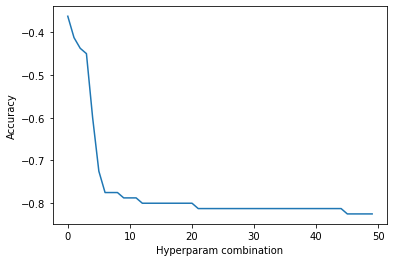

In [49]:
results['loss'].plot()
plt.ylabel('Accuracy')
plt.xlabel('Hyperparam combination')

In [50]:
pd.DataFrame(trials.results)['loss'].min()

-0.825